<div hidden=True>
    author: Marco Angius
    company: TomorrowData srl
    mail: marco.anguis@tomorrowdata.io
    notebook-version: oct19
    
</div>

# Hands-on: Supervised Learning
This section is meant for learning the Scikit-Learn APIs end provide a playground for machine learning supervised tasks.

[Scikit-Learn](https://scikit-learn.org/stable/index.html#) is a library for data mining and data analysis. It  includes models for classification, regression and clustering. It is built on top of NumPy. SciPy and matplotlib. 

For the purpose of this playground, to get familiar with the Scikit-Learn APis, we would use [Toy Datasets](https://scikit-learn.org/stable/datasets/index.html#toy-datasets) available in the library. 

Datasets in `sklearn.datasets` return a *Bunch*:
> Dictionary-like object, the interesting attributes are: ‘data’, the data to learn, ‘target’, the regression targets, ‘DESCR’, the full description of the dataset, and ‘filename’, the physical location of boston csv dataset (added in version 0.20).

### mglearn library 
For visualizing the results obtained with our models we are going to employ an existing library made by Andreas C. Muller (author of the book *Introduction to Machine Learning with Python*). The library is available in the [github repository](https://github.com/amueller/mglearn).

In [1]:
!pip install mglearn

In [2]:
!pip install graphviz

In [3]:
from sklearn.datasets import load_boston, load_diabetes, load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from IPython.display import Image
from six import StringIO

import pydotplus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import math

/home/marco/miniconda3/envs/handson-ml/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/marco/miniconda3/envs/handson-ml/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Dataset load
We will use the **boston house prices** and the **diabetes** dataset for regressions tasks. The **iris** and the **breast cancer** are used for multi-class and binary-class classification tasks respectively. 

In [4]:
boston_houses_ds = load_boston()
iris_ds = load_iris()
diabetes_ds = load_diabetes()
breast_ds = load_breast_cancer()

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 1**
- check the datasets. Use `print(ds.DESC)`to print information for each of them.

</div>

## K-Nearest Neighbor: Classification
The first model we are going to learn is the KNN which is a very simple model to start with. KNN can be used for both for classification or regression tasks. Here we are going to see classification first. 

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 2: Classification with KNN**
- split the breast cancer dataset in training and test sets 
- instantiate a KNN classifier specifying *n_neighbours* in the constructor
- fit the model on the training data
- make predictions on the test data
- observe the obtained performances
</div>

<div class="alert alert-success" role="alert">
    
<img src="./icons/lightbulb.png"  width="20" height="20" align="left"> &nbsp; **SciKit-Learn Tip 1: Models**

Models in scikit-learn follow all the same API. 

- to fit a model use the `model.fit(X_test, y_test)`
- to make predictions use the `model.predict(X_traing)`

In order to split the available data X,y in training and test use the `sklearn.model_selection.train_test_split(X, y)` function.

</div>

<div class="alert alert-success" role="alert">
    
<img src="./icons/lightbulb.png"  width="20" height="20" align="left"> &nbsp; **SciKit-Learn Tip 2: Metrics**

Also it is possible to evaluate the results by means of metrics. There are metrics for [classification](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) and [regression](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).

For now just use `metrics.accuracy_score(y_true, y_pred)` for classification tasks and `metrics.mean_squared_error(y_true, y_pred)` for regression tasks.

</div>


In [5]:
X, y = breast_ds.data, breast_ds.target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)

In [7]:
cknn = KNeighborsClassifier(n_neighbors=3)

In [8]:
cknn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [9]:
print("Training Set prediction score: {:.2f}%".format(accuracy_score(y_train, cknn.predict(X_train))*100))
print("Test Set prediction score: {:.2f}%".format(accuracy_score(y_test, cknn.predict(X_test))*100))

Training Set prediction score: 95.77%
Test Set prediction score: 92.31%


### KNN Model complexity

<div class="alert alert-warning" role="alert">
    
<img src="./icons/book.png"  width="20" height="20" align="left"> &nbsp;  **Theory: Model Complexity** 

The number of neighbors determines the complexity of the model. 

A lower value leads to a higher model complexity which means that the model would be very sensitive to noise (when a point of a class is in a region populated the most by the other class points). 

Vice versa, in the case of an higher number of neighbors used to evaluate the point's class the presence of noise is less relevant.
</div>

In [10]:
def plot_visual_boundaries(dataset, ranges, model=KNeighborsClassifier):
    # use only the first 2 features if more than 2 features
    X, y = dataset.data[:, :2] if dataset.data.shape[1] > 2 else dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)
    assert len(ranges) <= 3, "ranges lenght should be less or equal 3"
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for n_neighbors, ax in zip(ranges, axes):
        cknn_ = model(n_neighbors=n_neighbors).fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(cknn_, X_test, fill=True, eps=0.5, ax=ax, alpha=.4)
        mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, ax=ax)
        ax.set_title("{} neighbor(s)".format(n_neighbors), fontdict={'fontsize':15})
        ax.set_xlabel(dataset.feature_names[0], fontdict={'fontsize':13})
        ax.set_ylabel(dataset.feature_names[1], fontdict={'fontsize':13})

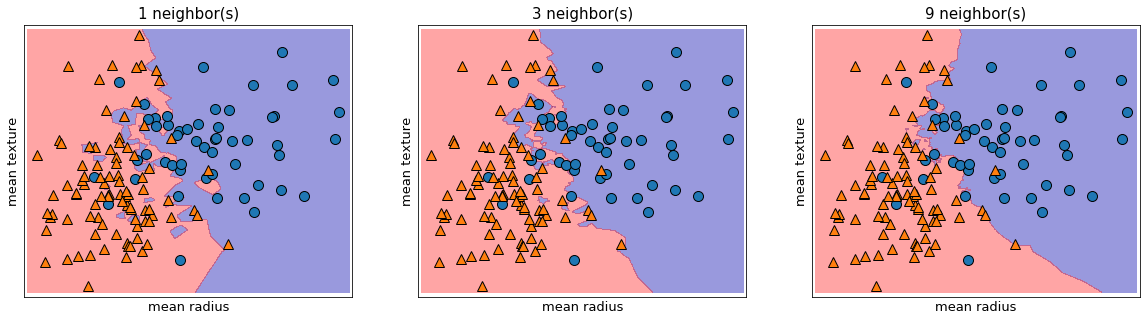

In [11]:
plot_visual_boundaries(breast_ds, [1, 3, 9])

### Which k ?
It is possible to train different models on different values of k and observe the performance of the model on the test set. 

In [12]:
def k_search_classification(dataset, ranges):
    X, y = dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)
    
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = ranges
    for n in neighbors_settings:
        cknn_ = KNeighborsClassifier(n_neighbors=n)
        cknn_.fit(X_train, y_train)
        training_accuracy.append(cknn_.score(X_train, y_train))
        test_accuracy.append(cknn_.score(X_test, y_test))
    
    plt.figure(figsize=[10, 5])
    plt.title("Accuracy for different k values", size=15)
    plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
    plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
    plt.ylabel("Accuracy", size=13)
    plt.xlabel("n_neighbors", size=13)
    plt.legend()

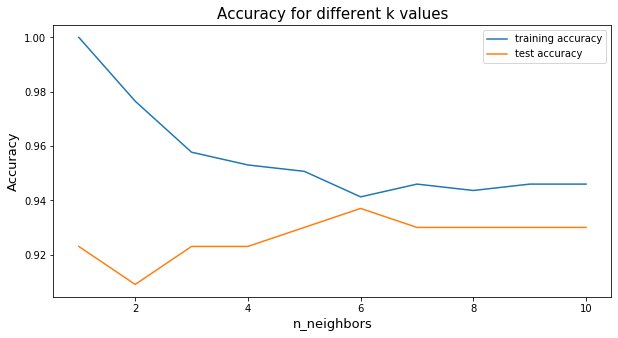

In [13]:
k_search_classification(breast_ds, range(1, 11))

<hr>

<div class="alert alert-danger" role="alert">
    
<img src="./icons/chemistry.png"  width="20" height="20" align="left"> &nbsp;  **Task 1**:  Try to repeat the experiments using the **iris** dataset. You can reuse the above function for searching the best k value.
</div>

## K-Nearest Neighbor: Regression


<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 3: Regression with KNN**
- split the diabetes dataset in training and test sets 
- instantiate a KNN classifier specifying *n_neighbours* in the constructor
- fit the model on the training data
- make predictions on the test data
- observe the obtained performances
</div>

### Regression Analysis 
We can observe how the model works on a single feature of the dataset on the given target.

In [14]:
def plot_regression(dataset, ranges, f_number=5):
    X, y = dataset.data[::4, f_number], dataset.target[::4]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
    assert len(ranges) <= 3, "ranges lenght should be less or equal 3"
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    line = np.linspace(min(X_train), max(X_train), 1000).reshape(-1, 1)
    for n_neighbors, ax in zip(ranges, axes):
        rknn_ = KNeighborsRegressor(n_neighbors=n_neighbors)
        rknn_.fit(X_train.reshape(-1, 1), y_train)
        ax.plot(line, rknn_.predict(line))
        ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
        ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)
        ax.set_title("{} neighbor(s)\n train score: {:.2f} test score: {:.2f}".format(
            n_neighbors, 
            rknn_.score(X_train.reshape(-1,1), y_train),
            rknn_.score(X_test.reshape(-1,1), y_test)))
        ax.set_xlabel("Feature")
        ax.set_ylabel("Target")
        axes[0].legend(["Model predictions", "Training data/target","Test data/target"], loc="best")

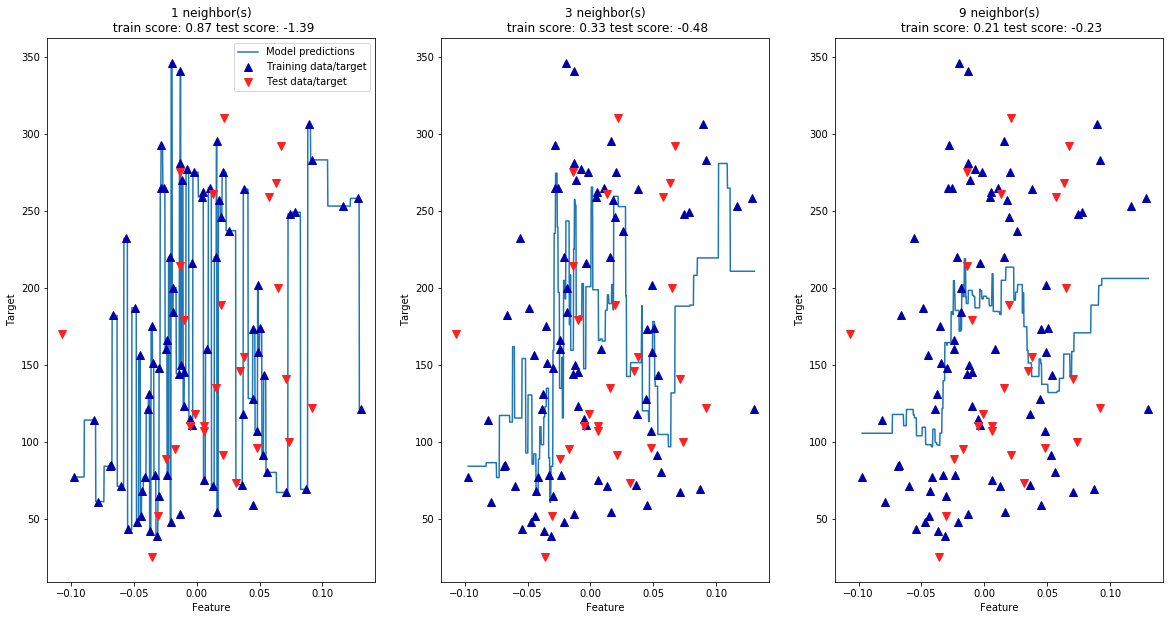

In [15]:
plot_regression(diabetes_ds, [1, 3, 9])

In [16]:
def k_search_regression(dataset, ranges):
    X, y = dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)
    
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = ranges
    for n in neighbors_settings:
        rknn_ = KNeighborsRegressor(n_neighbors=n)
        rknn_.fit(X_train, y_train)
        training_accuracy.append(mean_squared_error(y_train, rknn_.predict(X_train)))
        test_accuracy.append(mean_squared_error(y_test, rknn_.predict(X_test)))
    
    plt.figure(figsize=[10, 5])
    plt.title("MSE for different k values", size=15)
    plt.plot(neighbors_settings, training_accuracy, label="training mse")
    plt.plot(neighbors_settings, test_accuracy, label="test mse")
    plt.ylabel("MSE", size=13)
    plt.xlabel("n_neighbors", size=13)
    plt.legend()

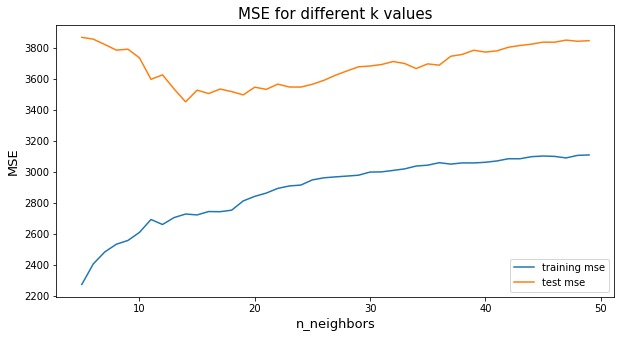

In [17]:
k_search_regression(diabetes_ds, range(5,50))

<hr>

<div class="alert alert-danger" role="alert">
    
<img src="./icons/chemistry.png"  width="20" height="20" align="left"> &nbsp;  **Task 2**:  Try to repeat the regression experiment using the **boston houses** dataset. 

You can reuse the above function for searching the best k value.
</div>

## Linear Models
The next model we are going to use predict the target by means of a linear function of the input features.
The general formula for regression tasks is: 

$$ \hat{y} = w[0] * x[0] + w[1] * x[1] + \dots + w[p] * x[p] + b $$

We have also seen that in the case of classification tasks we can employ a linear model for defining decision boundaries: 

$$ \hat{y} = w[0] * x[0] + w[1] * x[1] + \dots + w[p] * x[p] + b > 0 $$

For now we focus on regression tasks only

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 4: Linear Models**
- split the boston houses dataset in training and test sets 
- fit the model on the training data
- make predictions on the test data
- observe the obtained performances
- check the parameters' magnitude
</div>

In [18]:
X, y = boston_houses_ds.data, boston_houses_ds.target

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [20]:
lr = LinearRegression()

In [21]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
y_pred = lr.predict(X_test)

In [23]:
print("Training Set mean squared error: {:.2f}".format(mean_squared_error(y_train, lr.predict(X_train))))
print("Test Set mean squared error: {:.2f}".format(mean_squared_error(y_test, lr.predict(X_test))))

Training Set mean squared error: 18.88
Test Set mean squared error: 32.44


In [24]:
def plot_coefficients_given_models(dataset, models):
    models = [models] if not isinstance(models, list) else models
    
    f = plt.figure(figsize=[12, 7])
    ax = f.add_subplot()
    for m in models:
        ax.plot(range(0, len(dataset.feature_names)), m.coef_, 's', 
                label=str(m.__class__).strip("<>''").split(".")[-1])
    
    ax.set_title("Coefficients magnitued", fontdict={'fontsize':15})
    ax.set_xlabel("Coefficient index", fontdict={'fontsize':13})
    ax.set_ylabel("Feature", fontdict={'fontsize':13})
    ax.hlines(0, 0, len(m.coef_))
    ax.set_xticks(range(0, len(dataset.feature_names)))
    ax.set_xticklabels(dataset.feature_names)
    plt.legend()

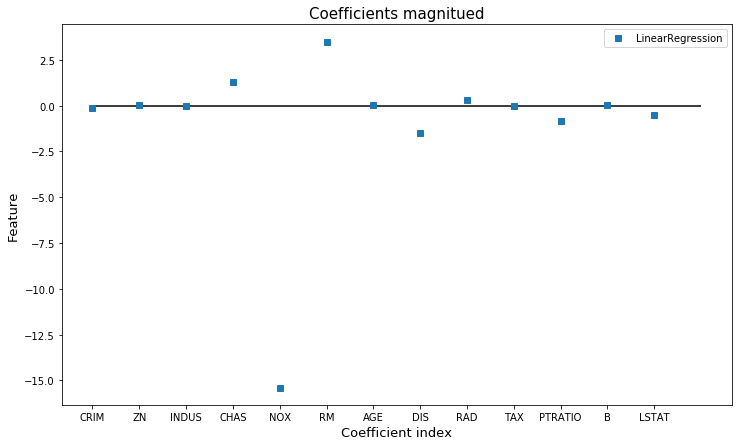

In [25]:
plot_coefficients_given_models(boston_houses_ds, lr)

## Compare Ridge e Lasso
Ordinary Least Square presents a regularization problem due to some of its coefficient magnitudes tends to assume high values fitting on the training data. Ridge and lasso add a constraint on the optimization function in order to limit these phenomena. 

The Ridge regularization: 
$$ \min_{w} || X w - y||_2^2 + \alpha ||w||_2^2 $$

The Lasso Regularization: 
$$ \min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1} $$

<div class="alert alert-danger" role="alert">
    
<img src="./icons/chemistry.png"  width="20" height="20" align="left"> &nbsp;  **Task 3**:  Try to repeat the regression experiment using `Ridge` and `Lasso` in order to compare the performances.

To see the different coefficient magnitudes use the `plot_coefficients_given_models` and pass a list of trained models in order to compare the results.
</div>

## Decision Tree
The last model we are going to see in this notebook is the Decision Tree for classification. We can compare the different scores obtained with the different classifiers and see witch performs better.

Please note that the decision tree has more hyperparameters in comparison with the K-Nearest Neighbor. The ones you can play with are: 
- `max_depth`: controls the complexity of the model
- `min_sample_split`: min number of samples to allow a split in an internal node. If the node is not split it is considered as a leaf, thus the distribution of samples in the leaf would affect the final decision.


<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 4: Decision Trees**
- split the breast dataset in training and test sets 
- fit the model on the training data
- make predictions on the test data
- observe the obtained performances
</div>

In [39]:
X, y = breast_ds.data, breast_ds.target

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10)

In [42]:
cdt = DecisionTreeClassifier(random_state=11)

In [43]:
cdt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=11, splitter='best')

In [44]:
print("Test Set prediction score: {:.2f}%".format(accuracy_score(y_test, cdt.predict(X_test))*100))

Test Set prediction score: 92.31%


### Visualize Decision Tree Structure
It is possible to check how the tree has been built. Use the below `plot_decision_tree(dataset, model)` function to plot the tree. You can also try with different parameters and see how those impact the tree construction.

<div class="alert alert-success" role="alert">
    
<img src="./icons/lightbulb.png"  width="20" height="20" align="left"> &nbsp; **SciKit-Learn Tip 3: Reproducibility**

Sometimes we want to have the same output across different runs of the algorithm. Due to the majority of them uses pseudo random generators it is possible to fix the seed of those using the `random_state` parameter.

</div>

In [47]:
def plot_decision_tree(dataset, model):
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data,
                    feature_names=dataset.feature_names,
                    class_names=True,
                    filled=True, rounded=True,
                    special_characters=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

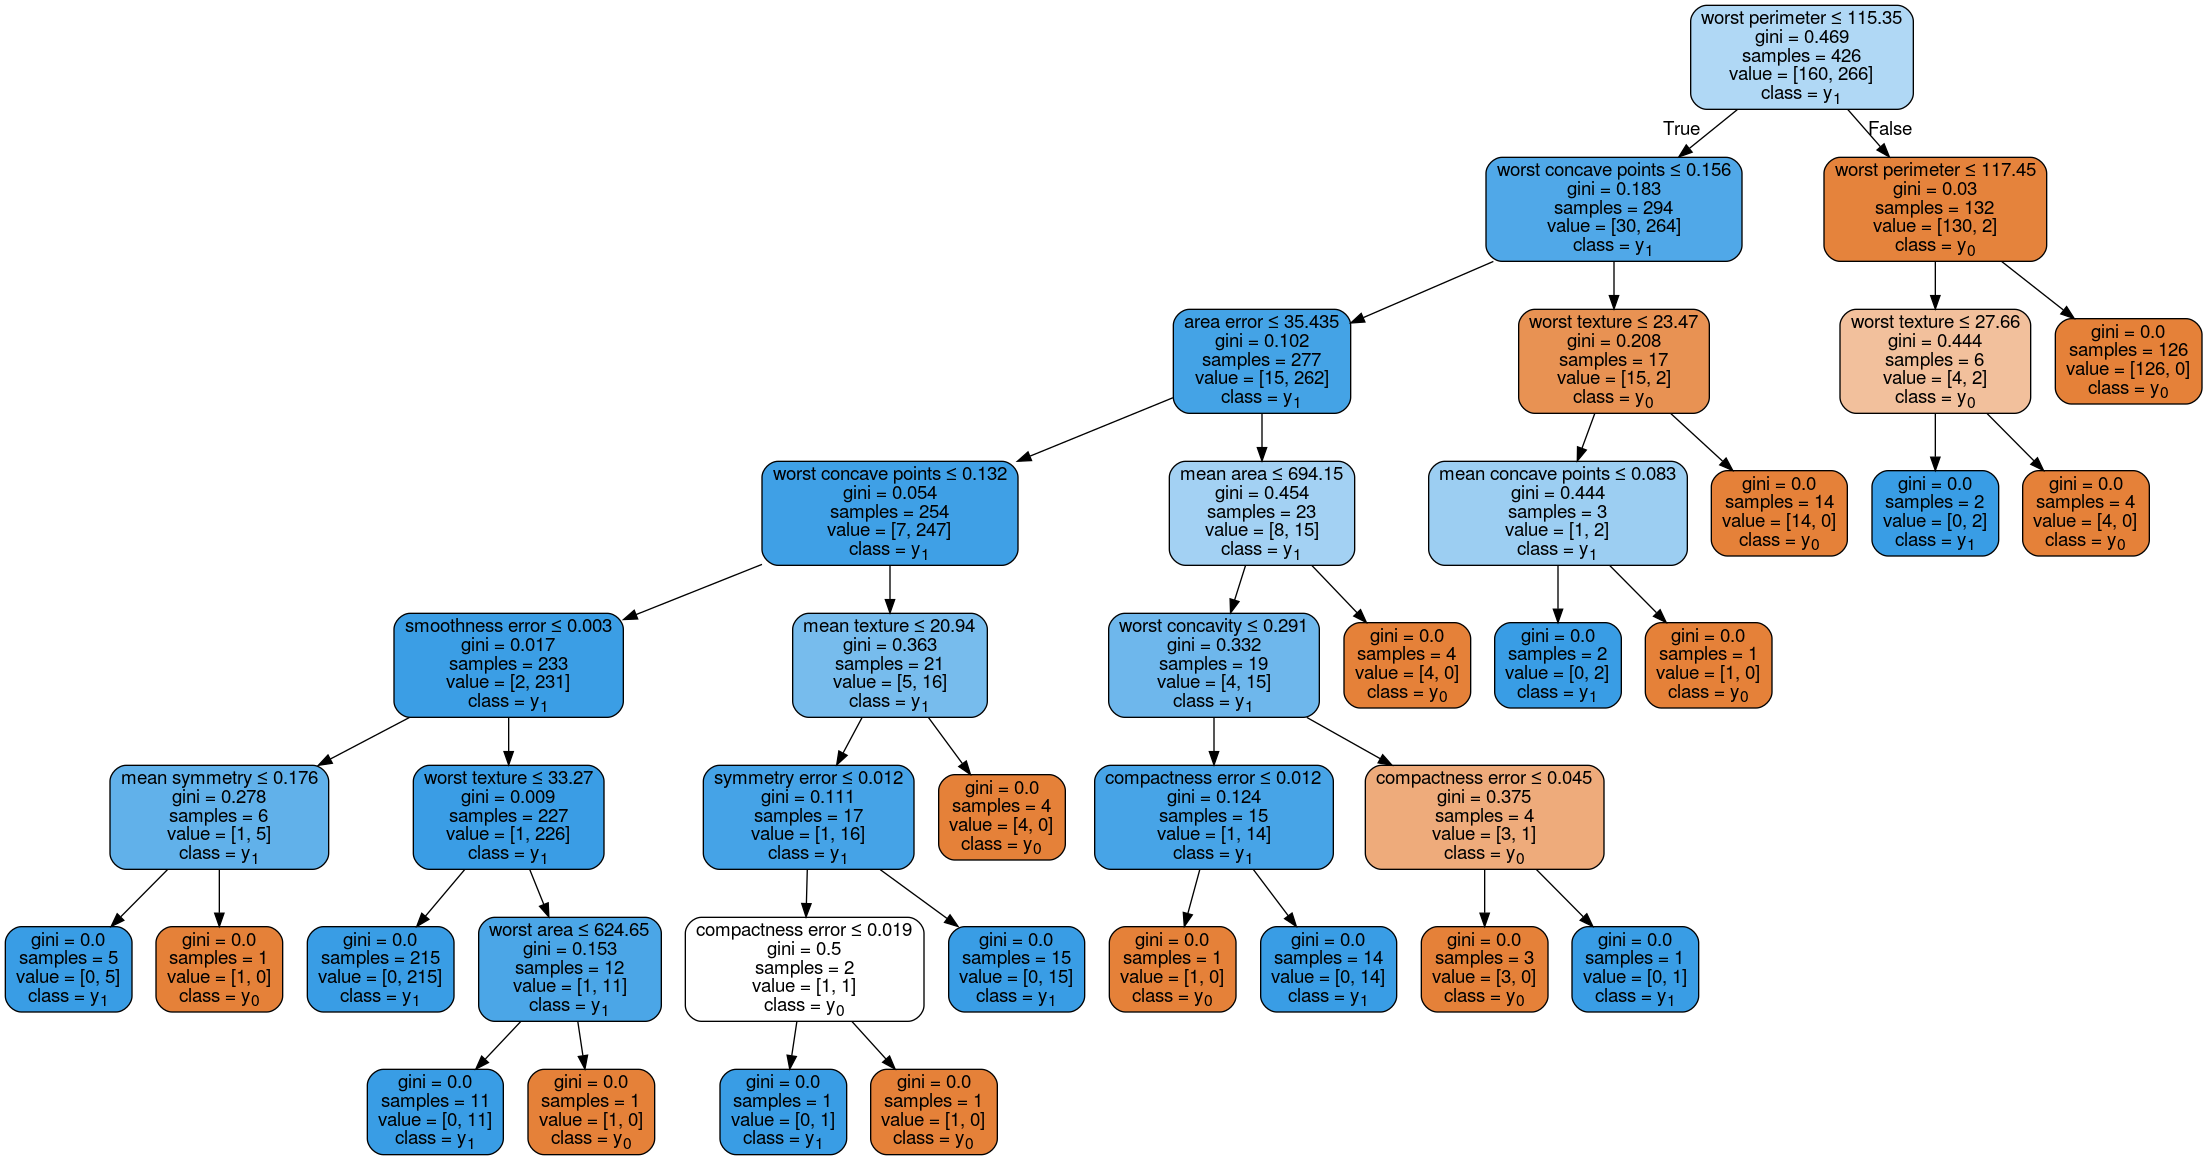

In [48]:
plot_decision_tree(breast_ds, cdt)

<div hidden=True><img src="./icons/book.png"  width="20" height="20" align="left"> &nbsp; Icon made by <a href="https://www.flaticon.com/authors/popcorns-arts" title="Icon Pond">Icon Pond</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a></div>